In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
from torchvision.models import regnet_y_16gf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from vit import VisionTransformer
from deit import DataEfficientImageTransformer as DEIT


In [27]:
%cd /content/drive/MyDrive/SMAI_TSNE

/content/drive/MyDrive/SMAI_TSNE


In [3]:
dataset_name = 'cifar100'

In [4]:
model = regnet_y_16gf()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model.load_state_dict(torch.load("regnet_y_16gf_32_3"))

<All keys matched successfully>

In [5]:
cifar100_trainset = dset.CIFAR10('./cifar100', train = True, download = True)

100%|██████████| 170498071/170498071 [00:01<00:00, 104015232.41it/s]


Extracting ./cifar100/cifar-10-python.tar.gz to ./cifar100


In [6]:
NUM_TRAIN = 0
r_mean, g_mean, b_mean = 0, 0, 0
r_std, g_std, b_std = 0, 0, 0

for d in cifar100_trainset:
    NUM_TRAIN += 1
    img = np.array(d[0])
    r_mean += np.mean(img[0], axis = None)
    g_mean += np.mean(img[1], axis = None)
    b_mean += np.mean(img[2], axis = None)

    r_std += np.std(img[0], axis = None)
    g_std += np.std(img[1], axis = None)
    b_std += np.std(img[2], axis = None)


r_mean = round(r_mean / NUM_TRAIN, 4)
g_mean = round(g_mean / NUM_TRAIN, 4)
b_mean = round(b_mean / NUM_TRAIN, 4)    

r_std = round(r_std / NUM_TRAIN, 4)
g_std = round(g_std / NUM_TRAIN, 4)
b_std = round(b_std / NUM_TRAIN, 4)

print(NUM_TRAIN)
print("Mean (RGB): ", r_mean, g_mean, b_mean)
print("SD   (RGB): ", r_std, g_std, b_std)

50000
Mean (RGB):  135.4809 134.1144 132.7762
SD   (RGB):  29.3508 31.4183 33.2274


In [7]:
NUM_TRAIN = round(0.966*len(cifar100_trainset))

transform = T.Compose([
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406], [0.228, 0.224, 0.225])
            ])

cifar100_trainset = dset.CIFAR100('./cifar100/', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar100_trainset, batch_size=256, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_testset = dset.CIFAR100('./cifar100/', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar100_testset, batch_size=256)

100%|██████████| 169001437/169001437 [00:01<00:00, 103315965.89it/s]


Extracting ./cifar100/cifar-100-python.tar.gz to ./cifar100/
Files already downloaded and verified


In [8]:
cifar100_trainset.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [9]:
a=iter(loader_train)
first_batch = next(a)

In [10]:
model=model.to('cuda:0')
out = model(first_batch[0].to('cuda:0'))

In [11]:
import seaborn as sns
import pickle as pkl
from tqdm.auto import tqdm
from sklearn.manifold import TSNE


sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [12]:
def get_embds(loader):

    for i, (data, labels) in tqdm(enumerate(loader_train)):
        data = data.to('cuda:0')
        labels = labels.to('cuda:0')

        out = model(data)
        # print(out)

        with torch.no_grad():

            if i == 0:
                out_embds = out.detach().cpu()
                labels_all = labels.detach().cpu()
    #             print(out_embds.shape)

            else:
                out_embds = torch.cat((out_embds, out.detach().cpu()), dim = 0)
                labels_all = torch.cat((labels_all, labels.detach().cpu()), dim = 0)
    
    return out_embds.numpy(), labels_all.numpy()

def tsne(arr):
    np_arr_embd_2d = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(arr)
    return np_arr_embd_2d

def get_inp(loader):
    
    for i, (data, labels) in tqdm(enumerate(loader_train)):
        
        x = data.view(data.shape[0], -1)
        
        if i == 0:
            out_embds =  x
        else:
            out_embds = torch.cat((out_embds, x), dim = 0)
    
    return out_embds.numpy()

In [13]:
out_embds, labels_all = get_embds(loader_train)

0it [00:00, ?it/s]

In [14]:
np_arr_embd_2d = tsne(out_embds)

<ipython-input-22-08c2740efc6e>:2: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)


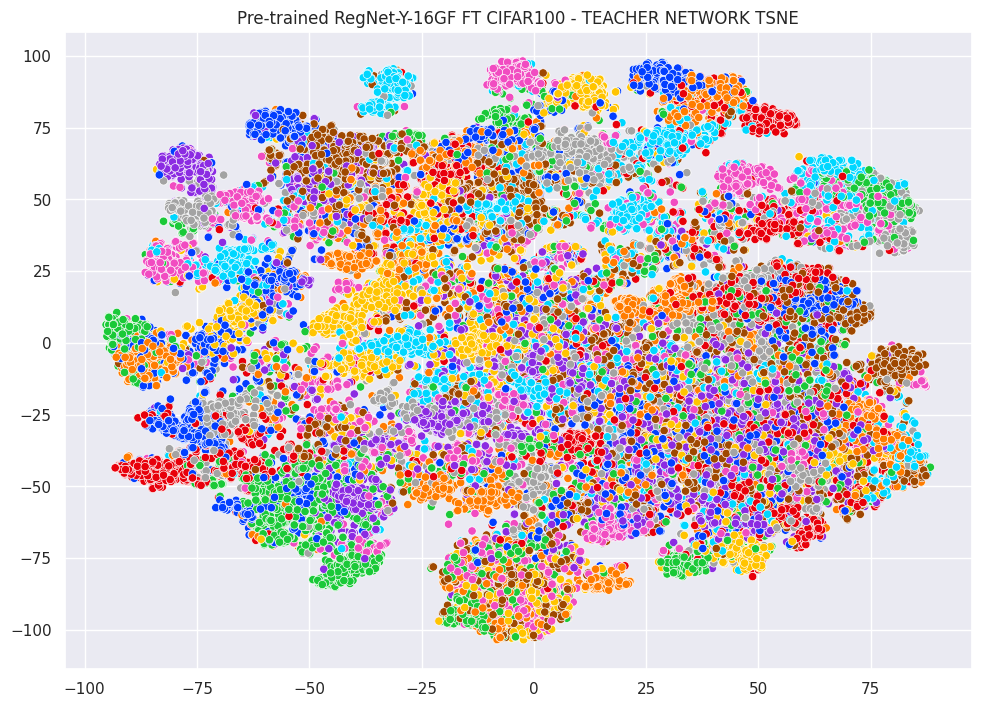

In [22]:
plt.title("Pre-trained RegNet-Y-16GF FT CIFAR100 - TEACHER NETWORK TSNE")
sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)
plt.savefig("teacher_network_CIFAR_TSNE.png")

### TSNE PLOT FOR DEIT-B SCRATCH

In [23]:
custom_config = {
        "img_size": 32,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4,
}

In [44]:
model = torch.load('/content/drive/MyDrive/SMAI_TSNE/VIT_B_cifar_scratch_38.pth').to("cuda:0")


In [45]:
out_embds, labels_all = get_embds(loader_train)
np_arr_embd_2d = tsne(out_embds)


0it [00:00, ?it/s]

<ipython-input-47-51f5ef06ec18>:2: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)


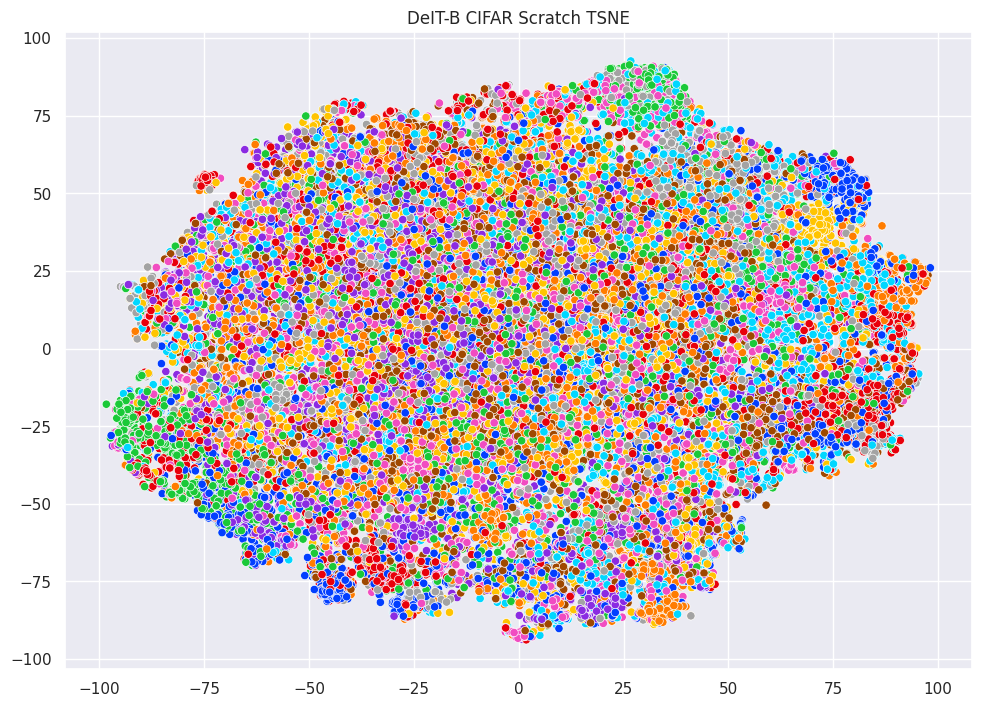

In [47]:
plt.title("DeIT-B CIFAR Scratch TSNE")
sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)
plt.savefig("deit_b_scratch_TSNE.png")

### VIT B Soft Distillation

In [48]:
model = VisionTransformer(**custom_config)
model = nn.Sequential(model, nn.Linear(1000,100, bias=True))
model.load_state_dict(torch.load("/content/drive/MyDrive/SMAI_TSNE/vitb_softdist_43"))
model.to("cuda:0")

Sequential(
  (0): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((768,), eps=1e-06, elementwise_aff

In [49]:
out_embds, labels_all = get_embds(loader_train)
np_arr_embd_2d = tsne(out_embds)

0it [00:00, ?it/s]

<ipython-input-51-5655bc7dbc3e>:2: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)


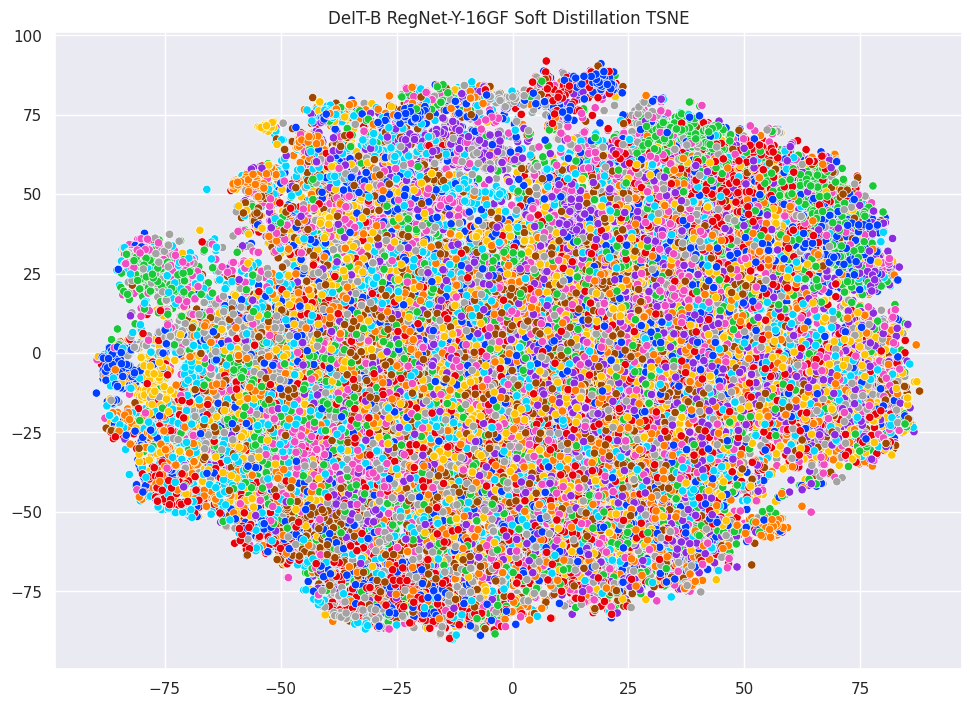

In [51]:
plt.title("DeIT-B RegNet-Y-16GF Soft Distillation TSNE")
sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)
plt.savefig("plots/deit_b_regnet16gf_soft_distill_TSNE.png")

In [52]:
model = VisionTransformer(**custom_config)
model = nn.Sequential(model, nn.Linear(1000,100, bias=True))
model.load_state_dict(torch.load("/content/drive/MyDrive/SMAI_TSNE/vit_b_reg16gf_hard_dist_53"))
model.to("cuda:0")

Sequential(
  (0): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((768,), eps=1e-06, elementwise_aff

In [53]:
out_embds, labels_all = get_embds(loader_train)
np_arr_embd_2d = tsne(out_embds)

0it [00:00, ?it/s]

<ipython-input-54-41bee4350389>:2: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)


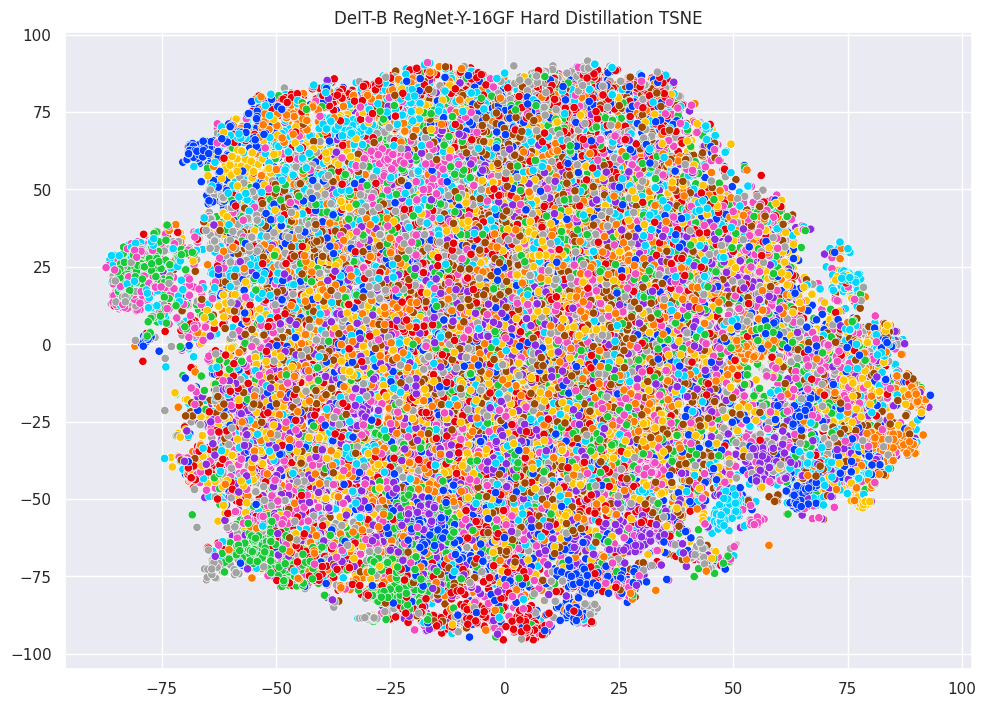

In [54]:
plt.title("DeIT-B RegNet-Y-16GF Hard Distillation TSNE")
sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)
plt.savefig("plots/deit_b_regnet16gf_hard_distill_TSNE.png")

### DeIT (Distillation Token) + Hard Distillation | Features for the Class Token 

In [67]:
model = DEIT(**custom_config)
model.load_state_dict(torch.load("/content/drive/MyDrive/SMAI_TSNE/vit_b_reg16gf_hard_dist_token_28"))
model.to("cuda:0")

DataEfficientImageTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (cls_head): Linear(in_features=768, out_f

In [66]:
# model(torch.ones((64, 3, 32, 32)).to('cuda:0'))[1].shape

torch.Size([64, 100])

In [68]:
def get_embds(loader):

    for i, (data, labels) in tqdm(enumerate(loader_train)):
        data = data.to('cuda:0')
        labels = labels.to('cuda:0')

        out = model(data)[0]
        # print(out)

        with torch.no_grad():

            if i == 0:
                out_embds = out.detach().cpu()
                labels_all = labels.detach().cpu()
    #             print(out_embds.shape)

            else:
                out_embds = torch.cat((out_embds, out.detach().cpu()), dim = 0)
                labels_all = torch.cat((labels_all, labels.detach().cpu()), dim = 0)
    
    return out_embds.numpy(), labels_all.numpy()

def tsne(arr):
    np_arr_embd_2d = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(arr)
    return np_arr_embd_2d

def get_inp(loader):
    
    for i, (data, labels) in tqdm(enumerate(loader_train)):
        
        x = data.view(data.shape[0], -1)
        
        if i == 0:
            out_embds =  x
        else:
            out_embds = torch.cat((out_embds, x), dim = 0)
    
    return out_embds.numpy()

In [69]:
out_embds, labels_all = get_embds(loader_train)
np_arr_embd_2d = tsne(out_embds)

0it [00:00, ?it/s]

<ipython-input-70-47931862fbda>:2: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)


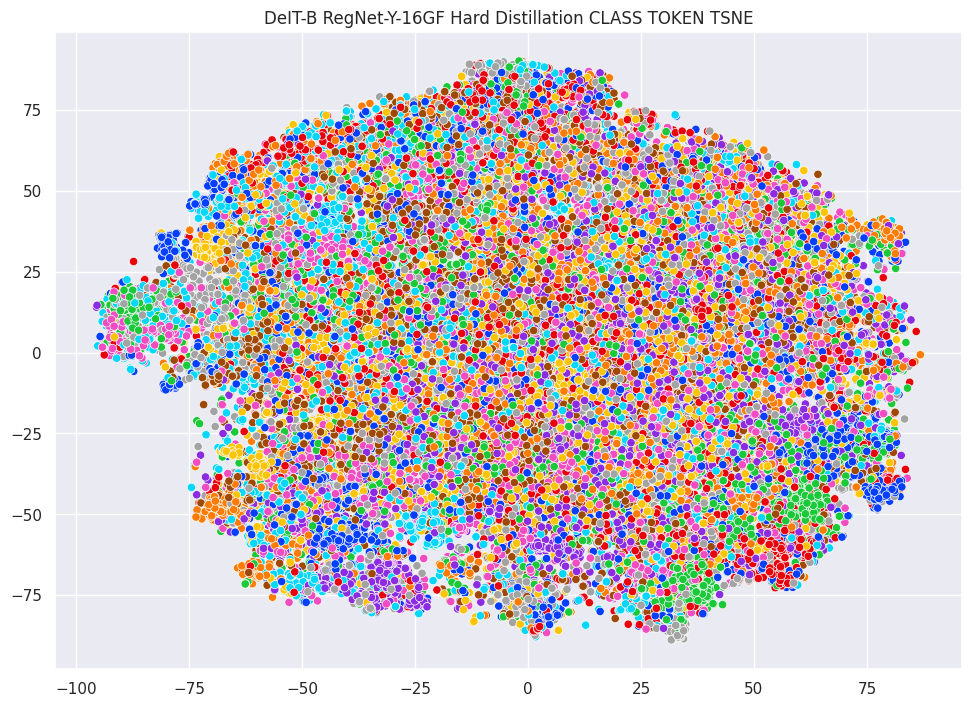

In [70]:
plt.title("DeIT-B RegNet-Y-16GF Hard Distillation CLASS TOKEN TSNE")
sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)
plt.savefig("plots/deit_b_regnet16gf_hard_distill__classToken_TSNE.png")

In [71]:
def get_embds(loader):

    for i, (data, labels) in tqdm(enumerate(loader_train)):
        data = data.to('cuda:0')
        labels = labels.to('cuda:0')

        out = model(data)[1]
        # print(out)

        with torch.no_grad():

            if i == 0:
                out_embds = out.detach().cpu()
                labels_all = labels.detach().cpu()
    #             print(out_embds.shape)

            else:
                out_embds = torch.cat((out_embds, out.detach().cpu()), dim = 0)
                labels_all = torch.cat((labels_all, labels.detach().cpu()), dim = 0)
    
    return out_embds.numpy(), labels_all.numpy()

def tsne(arr):
    np_arr_embd_2d = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(arr)
    return np_arr_embd_2d

def get_inp(loader):
    
    for i, (data, labels) in tqdm(enumerate(loader_train)):
        
        x = data.view(data.shape[0], -1)
        
        if i == 0:
            out_embds =  x
        else:
            out_embds = torch.cat((out_embds, x), dim = 0)
    
    return out_embds.numpy()

In [72]:
out_embds, labels_all = get_embds(loader_train)
np_arr_embd_2d = tsne(out_embds)

0it [00:00, ?it/s]

<ipython-input-73-828501b36242>:2: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)


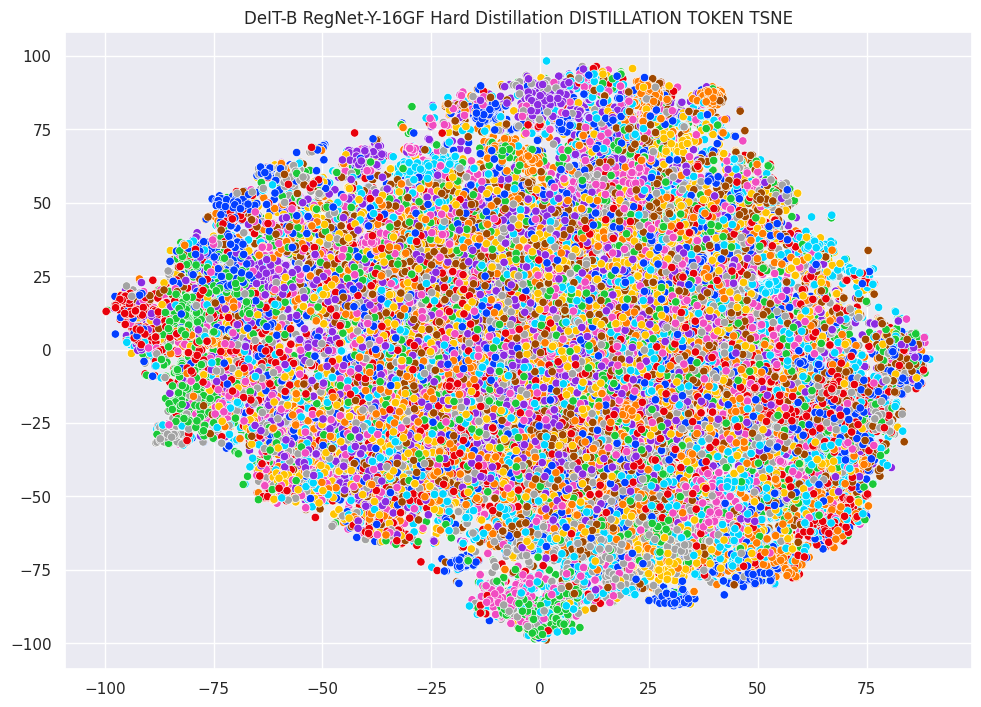

In [73]:
plt.title("DeIT-B RegNet-Y-16GF Hard Distillation DISTILLATION TOKEN TSNE")
sns.scatterplot(x=np_arr_embd_2d[:,0], y=np_arr_embd_2d[:,1], hue=labels_all, legend=False, palette=palette)
plt.savefig("plots/deit_b_regnet16gf_hard_distill__DistToken_TSNE.png")

## Finding Cosine Similarity Between Class and Dist Token

In [83]:
from scipy.spatial import distance
cos_dist = []
for i, (data, labels) in tqdm(enumerate(loader_train)):
        data = data.to('cuda:0')
        labels = labels.to('cuda:0')

        out_cls = torch.flatten(model(data)[0])
        out_dist = torch.flatten(model(data)[1])
        
        cos_dist.append(distance.cosine(out_cls.detach().cpu().numpy(), out_dist.detach().cpu().numpy()))


0it [00:00, ?it/s]

In [84]:
sum(cos_dist)/len(cos_dist)

0.10801156866487371

# 0.10801156866487371
